In [1]:
import torch
import sys

sys.path.append('..')

import SourceCode

In [2]:
from math import pi, e, sin
import torch
from SourceCode.utilities import nth_derivative, plot_two_curves
from SourceCode.EquationClass import MainEquationClass
from SourceCode.DomainClass import OneDimensionalSimpleDomain
from SourceCode.InitConditionClass import OnePointInitialCondition
from SourceCode.TrainerForNNEquationSolver import TrainerForNNEquationSolver
from SourceCode.ReportMaker import ReportMaker
import time


n_epochs = 10
n_points = 10
dh = 1e-3

# №0.1

$$ x'= -y $$
$$ y' = x + cost(t) $$
$$ x(0) = 0$$ $$y(0) = 0$$
$$t \in [0,1] $$
True_solution: $$x = -\frac{1}{2}tsin(t)$$ $$y = tcos(t) + \frac{1}{2}sin(t)$$

In [3]:
left_bound = 0
right_bound = 1
main_eq_residual1 = lambda t, x, y: nth_derivative(x(t), t, 1) + y(t)
main_eq_residual2 = lambda t, x, y: nth_derivative(y(t), t, 1) - x(t) - torch.cos(t)
main_eq_residuals = [main_eq_residual1, main_eq_residual2]
n_points = 20

main_domain = OneDimensionalSimpleDomain(left_bound, 
                                         right_bound, 
                                         n_points)


first_init_cond_res = lambda x, nn_model1, nn_model2: nn_model1(x) - 0
first_init_cond = OnePointInitialCondition(left_bound, 
                                           first_init_cond_res)

second_init_cond_res = lambda x, nn_model1, nn_model2: nn_model2(x) - 0
second_init_cond = OnePointInitialCondition(left_bound, 
                                            second_init_cond_res)

boundary_conditions = [first_init_cond, second_init_cond]

main_eq = MainEquationClass(main_domain, 
                                     main_eq_residuals, 
                                     boundary_conditions)


nn_ode_solver = TrainerForNNEquationSolver(main_eq)
loss_train, loss_valid, nn_models = nn_ode_solver.fit()

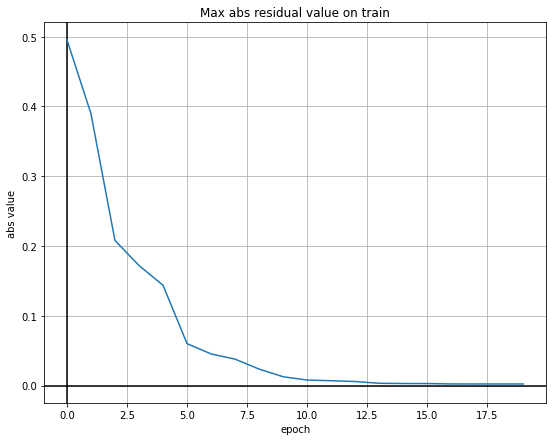

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.0002387251442996785
Valid max absolute error |Appr(x)-y(x)|: 0.0002350553113501519
MAPE on train data: 0.020995944214519113 %
MAPE on validation data: 0.021477023256011307 %
Max abs value of residual on train at last epoch: 0.0021953284740448 


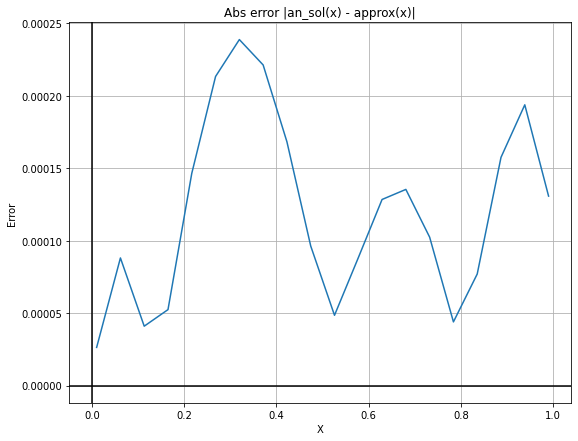

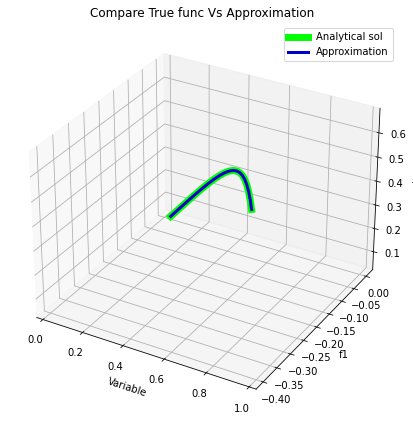

In [4]:
analytical_solution1 = lambda x: -1/2 * x * torch.sin(x)
analytical_solution2 = lambda x: 1/2*(x*torch.cos(x) + torch.sin(x))
analytical_solutions = [analytical_solution1, analytical_solution2]

report = ReportMaker(nn_models,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_curves,
                         analytical_solutions=analytical_solutions
                         )
report.print_loss_history()
report.compare_appr_with_analytical()

# № 0.2 #

$$ x'= -y $$
$$ y' = x + cost(t) $$
$$ x(0) = 0$$ $$y(0) = 0$$
$$t \in [0,5] $$
True_solution: $$x = -\frac{1}{2}tsin(t)$$ $$y = tcos(t) + \frac{1}{2}sin(t)$$
Approximation satisfying boundary conditions: $$ apprX(t) = t*nn_1(t) $$
$$ apprY(t) = t*nn_2(t) $$

In [5]:
left_bound = 0
right_bound = 5
main_eq_residual1 = lambda t, x, y: nth_derivative(x(t), t, 1) + y(t)
main_eq_residual2 = lambda t, x, y: nth_derivative(y(t), t, 1) - x(t) - torch.cos(t)
main_eq_residuals = [main_eq_residual1, main_eq_residual2]
n_points = 20

dh = 0.001
main_domain = OneDimensionalSimpleDomain(left_bound, right_bound, n_points)

main_eq = MainEquationClass(main_domain, main_eq_residuals)
boundary_satisfying_models = [
        lambda x, model1: x * model1(x),
        lambda x, model2: x * model2(x)
    ]

n_epochs = 20
nn_ode_solver = TrainerForNNEquationSolver(main_eq,
                                               n_epochs=n_epochs,
                                               act_func=torch.tanh,
                                               boundary_satisfying_models=boundary_satisfying_models)
loss_train, loss_valid, nn_models = nn_ode_solver.fit()


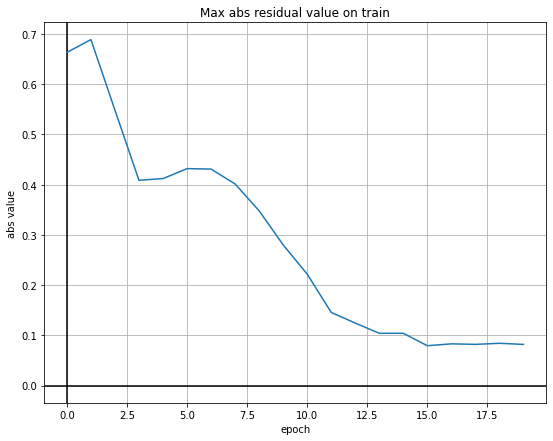

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.026617441326379776
Valid max absolute error |Appr(x)-y(x)|: 0.02870427630841732
MAPE on train data: 0.9018596261739731 %
MAPE on validation data: 0.9125212207436562 %
Max abs value of residual on train at last epoch: 0.08185088634490967 


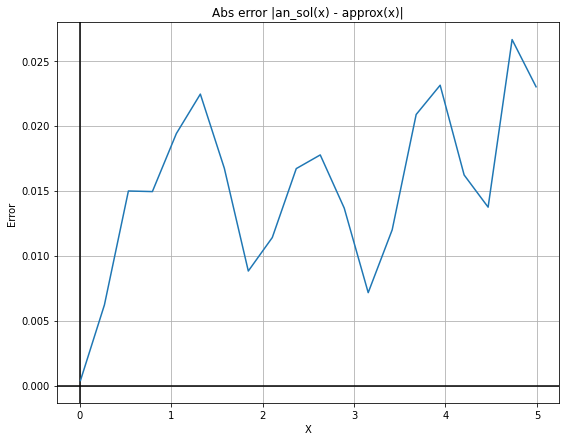

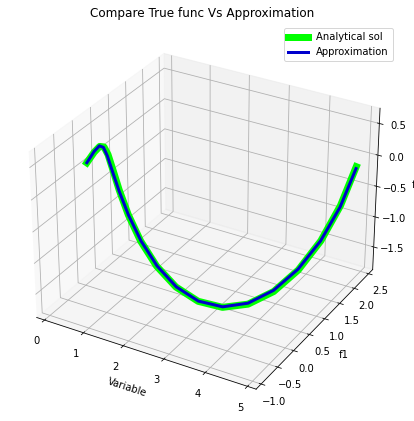

In [6]:
analytical_solution1 = lambda x: -1 / 2 * x * torch.sin(x)
analytical_solution2 = lambda x: 1 / 2 * (x * torch.cos(x) + torch.sin(x))
analytical_solutions = [analytical_solution1, analytical_solution2]
report = ReportMaker(nn_models,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_curves,
                         analytical_solutions=analytical_solutions
                         )
report.print_loss_history()
report.compare_appr_with_analytical()

# № 1

$$ D^{0.5}y_1 = x^{0.5}cos(x)+y_1+y_2 -(e^x+sin(x)) $$
$$ D^{0.75}y_2 = x^{0.25}e^x+y_1-sin(x) $$
$$ <=> $$
$$ x^{0.5}y_1'(x)= x^{0.5}cos(x)+y_1+y_2 -(e^x+sin(x))$$
$$ x^{0.25}y_2'(x) = x^{0.25}e^x+y_1-sin(x) $$
$$ y_1(0) = 0$$ $$y_2(0) = 1$$
$$x \in [0,1] $$
True_solution: $$y_1 = sin(x)$$ $$y_2 = e^x$$

In [7]:
left_bound = 0
right_bound = 1
main_eq_residual1 = lambda x, y1, y2: (torch.pow(x,0.5)*nth_derivative(y1(x), x, 1)
                                       -x**(0.5)*torch.cos(x)
                                       - y1(x)-y2(x) + torch.exp(x) + torch.sin(x))
main_eq_residual2 = lambda x, y1, y2: (x**(0.25)*nth_derivative(y2(x), x, 1) - 
                                       pow(x,0.25)*torch.exp(x)
                                      -y1(x) + torch.sin(x))
main_eq_residuals = [main_eq_residual1, main_eq_residual2]
n_points = 20

main_domain = OneDimensionalSimpleDomain(left_bound, 
                                         right_bound, 
                                         n_points)


first_init_cond_res = lambda x, nn_model1, nn_model2: nn_model1(x)
first_init_cond = OnePointInitialCondition(left_bound, first_init_cond_res)

second_init_cond_res = lambda x, nn_model1, nn_model2: (nn_model2(x) 
                                                        - torch.tensor([1.0], requires_grad=True))
second_init_cond = OnePointInitialCondition(left_bound, second_init_cond_res)

boundary_conditions = [first_init_cond, second_init_cond]

main_eq = MainEquationClass(main_domain, main_eq_residuals, boundary_conditions)

n_epochs = 20
nn_ode_solver = TrainerForNNEquationSolver(main_eq, n_epochs=n_epochs, act_func = torch.tanh)
loss_train, loss_valid, nn_models = nn_ode_solver.fit()

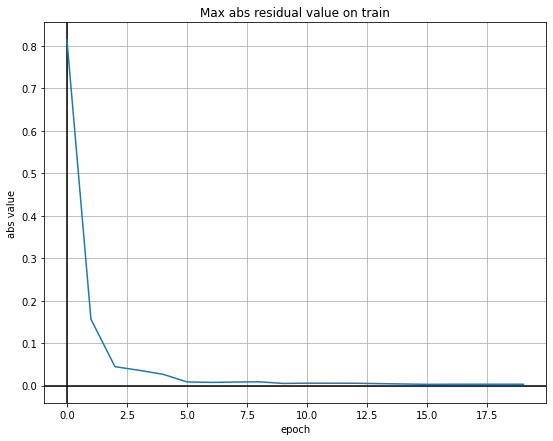

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.021761519834399223
Valid max absolute error |Appr(x)-y(x)|: 0.02080848254263401
MAPE on train data: 0.4542587324976921 %
MAPE on validation data: 0.4507407546043396 %
Max abs value of residual on train at last epoch: 0.002965688705444336 


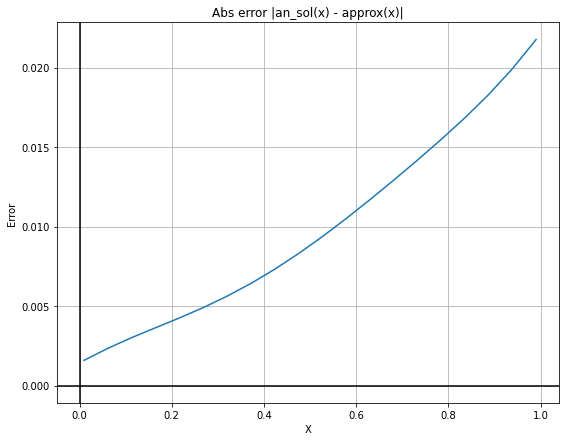

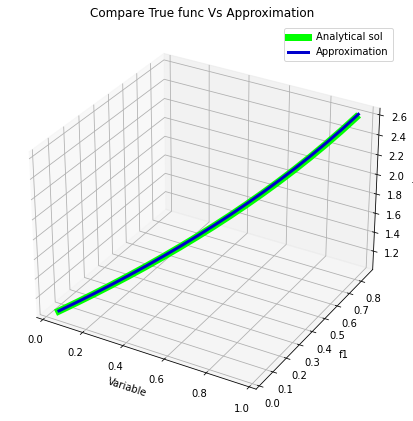

In [8]:
analytical_solution1 = lambda x: torch.sin(x)
analytical_solution2 = lambda x: torch.exp(x)
analytical_solutions = [analytical_solution1, analytical_solution2]
report = ReportMaker(nn_models,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_curves,
                         analytical_solutions=analytical_solutions
                         )
report.print_loss_history()
report.compare_appr_with_analytical()

In [9]:
report.print_comparison_table()

train data
     Input_X  Analytical_F1    ANN_F1  Analytical_F2    ANN_F2  Abs error
0   0.010000       0.010000  0.011537       1.010050  1.010428   0.001583
1   0.061579       0.061540  0.063717       1.063514  1.064379   0.002342
2   0.113158       0.112917  0.115672       1.119809  1.121027   0.003013
3   0.164737       0.163993  0.167306       1.179083  1.180570   0.003632
4   0.216316       0.214633  0.218517       1.241494  1.243210   0.004246
5   0.267895       0.264702  0.269197       1.307209  1.309151   0.004896
6   0.319474       0.314067  0.319231       1.376403  1.378601   0.005612
7   0.371053       0.362597  0.368497       1.449259  1.451768   0.006411
8   0.422632       0.410162  0.416869       1.525972  1.528861   0.007303
9   0.474211       0.456636  0.464216       1.606745  1.610091   0.008285
10  0.525789       0.501896  0.510405       1.691794  1.695670   0.009350
11  0.577368       0.545821  0.555305       1.781345  1.785814   0.010484
12  0.628947       0.588294

In [10]:
left_bound = 0
right_bound = 1
main_eq_residual1 = lambda x, y1, y2: (x*x*nth_derivative(y1(x), x, 1) + x*y1(x)
                                       +x**(0.15)*nth_derivative(y2(x), x, 1)
                                       - 2*x**(1.15)-x*y1(x)-y2(x)+torch.tensor([1.0],requires_grad=True))
main_eq_residual2 = lambda x, y1, y2: (x**(0.25)*nth_derivative(y1(x), x, 1) + x*x*nth_derivative(y2(x), x, 1)
                                      +x*y2(x)
                                       + 2 * x - x**(0.25) - 3*y1(x)*y2(x))
main_eq_residuals = [main_eq_residual1, main_eq_residual2]
n_points = 20

main_domain = OneDimensionalSimpleDomain(left_bound, right_bound, n_points)

boundary_satisfying_models = [
        lambda x, model1: x * model1(x),
        lambda x, model2: (x-torch.tensor([1.0],requires_grad=True)) * model2(x)
    ]

main_eq = MainEquationClass(main_domain, main_eq_residuals)


nn_ode_solver = TrainerForNNEquationSolver(main_eq,
                                               n_epochs=n_epochs,
                                               act_func=torch.tanh,
                                               boundary_satisfying_models=boundary_satisfying_models)
loss_train, loss_valid, nn_models = nn_ode_solver.fit()

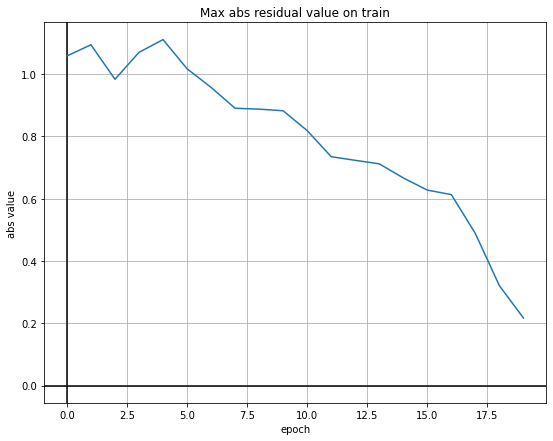

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 2.8629162311553955
Valid max absolute error |Appr(x)-y(x)|: 2.805091142654419
MAPE on train data: 106.53843879699707 %
MAPE on validation data: 107.6525330543518 %
Max abs value of residual on train at last epoch: 0.2167954444885254 


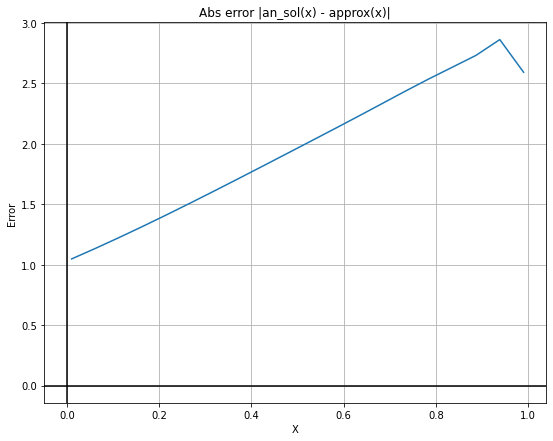

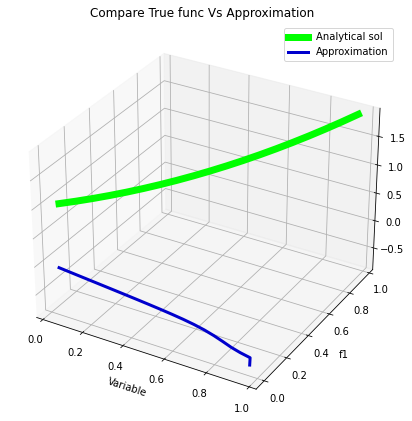

In [11]:
analytical_solution1 = lambda x: x
analytical_solution2 = lambda x: x*x + 1
analytical_solutions = [analytical_solution1, analytical_solution2]
report = ReportMaker(nn_models,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_curves,
                         analytical_solutions=analytical_solutions
                         )
report.print_loss_history()
report.compare_appr_with_analytical()